In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.9 MB/s eta 0:00:00


In [2]:
!pip install eeglabio

In [12]:
import mne
import numpy as np
import pandas as pd
from mne.export import export_raw
import matplotlib.pyplot as plt

# Load EEG Data

In [13]:
fname = "/content/20250507144049_p4kushi_task_pre_task.edf"
raw = mne.io.read_raw_edf(fname, preload=True)
print(raw.info)

# Drop extra channels if present
drop_chs = [ch for ch in ['X', 'Y', 'Z'] if ch in raw.ch_names]
if drop_chs:
    raw.drop_channels(drop_chs)
    print(f"Removed channels: {drop_chs}")

# Apply standard 10-20 montage
try:
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    print("Applied standard 10–20 montage.")
except Exception as e:
    print(f"Could not apply montage: {e}")

Extracting EDF parameters from /content/20250507144049_p4kushi_task_pre_task.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 377499  =      0.000 ...   754.998 secs...


/tmp/ipython-input-3791626578.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(fname, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AFz, Fp2, Fp1, Fpz, Fz, FC2, ...
 chs: 35 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2025-05-07 14:40:49 UTC
 nchan: 35
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
Removed channels: ['X', 'Y', 'Z']
Applied standard 10–20 montage.


#Extract Events

In [14]:
events, event_id = mne.events_from_annotations(raw)
print("Event keys:", event_id)

def find_event(name, event_id):
    return [v for k, v in event_id.items() if name.lower() in k.lower()]

centreclick_ids = find_event('Trigger#3', event_id)
if not centreclick_ids:
    raise ValueError("No Trigger#3 events found!")

centre_events = events[np.isin(events[:, 2], centreclick_ids)]
timestamp_centre = centre_events[:, 0] / raw.info['sfreq']
print("Centre click timestamps (s):", timestamp_centre)

Used Annotations descriptions: [np.str_('Trigger#1'), np.str_('Trigger#2'), np.str_('Trigger#3'), np.str_('Trigger#4'), np.str_('Trigger#5'), np.str_('Trigger#6'), np.str_('Trigger#7')]
Event keys: {np.str_('Trigger#1'): 1, np.str_('Trigger#2'): 2, np.str_('Trigger#3'): 3, np.str_('Trigger#4'): 4, np.str_('Trigger#5'): 5, np.str_('Trigger#6'): 6, np.str_('Trigger#7'): 7}
Centre click timestamps (s): [138.008 146.66  180.394 187.926 207.01  210.776 213.76  216.576 219.274
 222.508 227.092 236.742 239.944 245.042 248.26  251.374 254.21  256.91
 260.742 263.574 267.676 273.926 279.874 285.076 289.626 298.21  302.142
 305.792 308.842 315.276 318.94  321.958 325.342 328.14  330.642 333.508
 336.01  339.742 342.526 345.026 349.592 352.258 354.774 357.342 359.958
 362.526 364.608 367.308 373.524 377.624 380.658 383.274 385.874 388.458
 391.008 393.374 400.658 403.324 406.174 409.84  413.14  417.042 420.174
 423.708 429.658 432.442 441.54  444.658 447.942 450.724 453.358 456.108
 459.342 471.7

# Load Decision Labels

In [15]:
csv_path = "/content/data_env1_p4kushi_p4_001_.csv"
df_labels = pd.read_csv(csv_path)
df_labels.columns = df_labels.columns.str.strip().str.lower()
print(df_labels.head())

   unnamed: 0  tree number  time elapsed decision  reaction time  reward  \
0           0            1      9.689186     stay       0.688388      94   
1           1            1     38.564136     stay       5.296787      83   
2           2            1     51.380820     stay       0.946989      75   
3           3            1     58.526280     stay       1.042366      63   
4           4            1     75.175353     stay       1.225131      60   

   cumulative reward per tree  total cumulative reward  
0                          94                       94  
1                         177                      177  
2                         252                      252  
3                         315                      315  
4                         375                      375  


# Create 1 second pre trigger Epochs

In [16]:
sfreq = raw.info['sfreq']
window_sec = 1.0
blocks, meta_rows = [], []

for i, t_end in enumerate(timestamp_centre):
    if i < len(df_labels):
        decision = str(df_labels.loc[i, 'decision']).strip().lower()
        rt = df_labels.loc[i, 'reaction time']
        rew = df_labels.loc[i, 'reward']
    else:
        continue

    if decision not in ['stay', 'leave']:
        continue

    t_start = max(0, t_end - window_sec)
    block = raw.copy().crop(tmin=t_start, tmax=t_end)


    if 'STI 014' not in block.ch_names:
        stim_data = np.zeros((1, block.n_times))
        info_stim = mne.create_info(ch_names=['STI 014'],
                                    sfreq=block.info['sfreq'],
                                    ch_types=['stim'])
        stim_raw = mne.io.RawArray(stim_data, info_stim)
        block.add_channels([stim_raw], force_update_info=True)

    event_sample = block.n_times - 5
    latency_sec = block.times[event_sample]
    block.set_annotations(mne.Annotations(onset=[latency_sec],
                                          duration=[0],
                                          description=[decision]))

    meta_rows.append({'epoch_index': i,
                      'decision': decision,
                      'reaction_time': rt,
                      'reward': rew})

    print(f"Epoch {i+1}: {t_start:.3f}-{t_end:.3f}s | {decision}")
    blocks.append(block)

Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 1: 137.008-138.008s | stay
Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 2: 145.660-146.660s | stay
Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 3: 179.394-180.394s | stay
Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 4: 186.926-187.926s | stay
Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 5: 206.010-207.010s | stay
Creating RawArray with float64 data, n_channels=1, n_times=501
    Range : 0 ... 500 =      0.000 ...     1.000 secs
Ready.
Epoch 6: 209.776-210.776s | stay
Creating RawArray with float64 data, n_channels=1, n_times

# Combine all Epochs

In [17]:
raw_combined = mne.concatenate_raws(blocks)
print(f"Total epochs included: {len(blocks)}")

Total epochs included: 66


In [18]:
save_path_set = "/content/p4_prestim.set"
export_raw(save_path_set, raw_combined, fmt='eeglab', overwrite=True)
print(f"✅ Saved EEGLAB file: {save_path_set}")

# Save metadata
meta_df = pd.DataFrame(meta_rows)
meta_csv = "/content/p4_prestim_epochs_metadata.csv"
meta_df.to_csv(meta_csv, index=False)
print(f"✅ Saved metadata: {meta_csv}")

✅ Saved EEGLAB file: /content/p4_prestim.set
✅ Saved metadata: /content/p4_prestim_epochs_metadata.csv


# ERP Check

Used Annotations descriptions: [np.str_('leave'), np.str_('stay')]
Not setting metadata
66 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 66 events and 501 original time points ...
1 bad epochs dropped
Events in epochs: (65, 3)
Event types: {'stay': 1, 'leave': 2}


<Figure size 640x480 with 0 Axes>

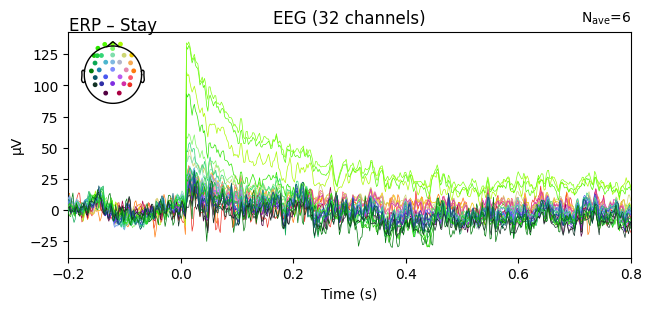

<Figure size 640x480 with 0 Axes>

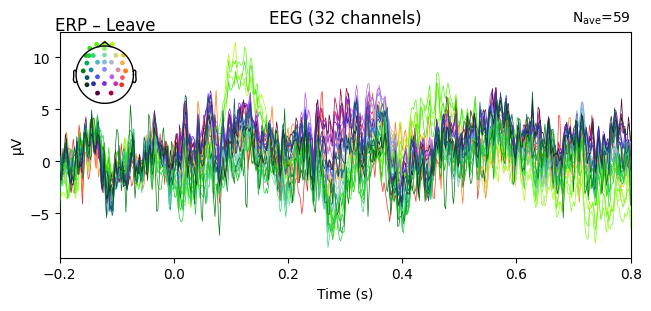

In [19]:
events_combined, _ = mne.events_from_annotations(raw_combined)
epochs = mne.Epochs(raw_combined, events_combined,
                    event_id={'stay': 1, 'leave': 2},
                    tmin=-0.2, tmax=0.8,
                    baseline=(None, 0),
                    preload=True,
                    reject_by_annotation=False)

print("Events in epochs:", epochs.events.shape)
print("Event types:", epochs.event_id)

erp_stay = epochs['stay'].average()
erp_leave = epochs['leave'].average()

plt.figure(); erp_stay.plot(spatial_colors=True, show=False)
plt.title("ERP – Stay"); plt.show()

plt.figure(); erp_leave.plot(spatial_colors=True, show=False)
plt.title("ERP – Leave"); plt.show()
